# Ultrasound breast imaging with Forge

In this notebook we solve the forward problem, generating true synthetic ultrasound for the 2D Anastasio breast model. 

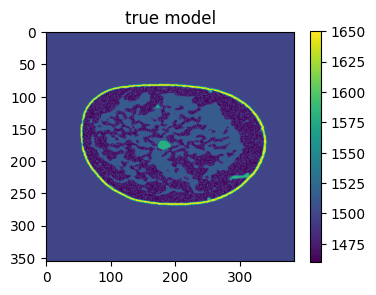

In [1]:
import numpy as np

# Load the 2D anastasio breast model and set a water starting model
m = np.load('./data/anastasio2D.npy')
dx = 5e-4

import matplotlib.pyplot as plt

# Plot the true model
plt.figure(figsize=(4, 3))
plt.imshow(m)
plt.title('true model')
plt.colorbar()
plt.show()

In [2]:
# Load the transducer geometry coordinates in meters
r_geometry = np.load('./data/geometry.npy')
s_geometry = r_geometry.copy()

In [3]:
# Set the source frequency and minimum number of grid-points per wavelength
frequency = 5e5
gridpoints_per_wavelength = 5

# Calculate new grid spacing required to ensure the minimum number of grid-points per wavelength
min_wavelength = m.min()/frequency
dxi = min_wavelength/gridpoints_per_wavelength

In [4]:
# Convert geometry coordinates from meters to grid-cells
r_posi = r_geometry/dxi
s_posi = s_geometry/dxi

In [5]:
from forge.utils import resample

# Interpolate models to required grid-spacing dxi
mi = resample(m, dx, dxi)

In [6]:
# Set the temporal increment, dt, to be small enough to meet the CFL condition for numerical stability
courant = 0.6
dt = (courant*dxi)/mi.max()

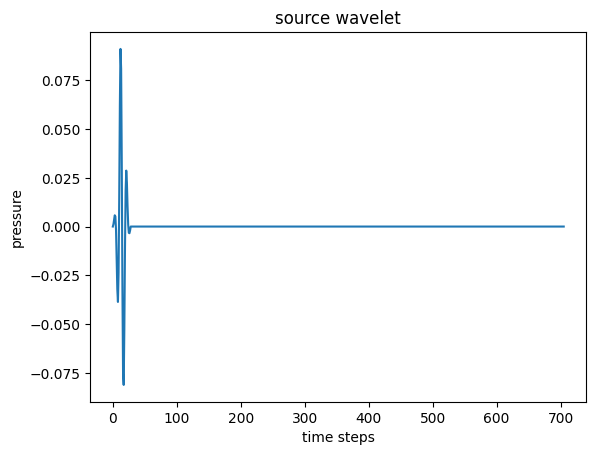

In [7]:
from forge.utils import tone_burst

time = 0.00015  # Maximum time in seconds
amplitude = 1e-1  #  Maximum source pressure 
num = round(time/dt) #  Number of time-steps
num_cycles = 3  # Use a 3 cycle tone-burst

# Define the source wavelet 
source = tone_burst(dt, frequency, num_cycles, num, amplitude, plot=True)

In [8]:
from forge.model import FullWaveformInversion

# Instantiate a FullWaveformInversion class
true_model = FullWaveformInversion(model = mi,  # True model
                           dx = dxi,  # Spatial increment
                           dt = dt,  # Temporal increment
                           r_pos = r_posi,  # Receiver positions
                           sampling_rate=len(source))

# Forward modelling 
true_model.forward(s_posi, source)

device = cuda:0


forward modelling: 100%|██████████████████████| 706/706 [00:44<00:00, 15.94it/s]


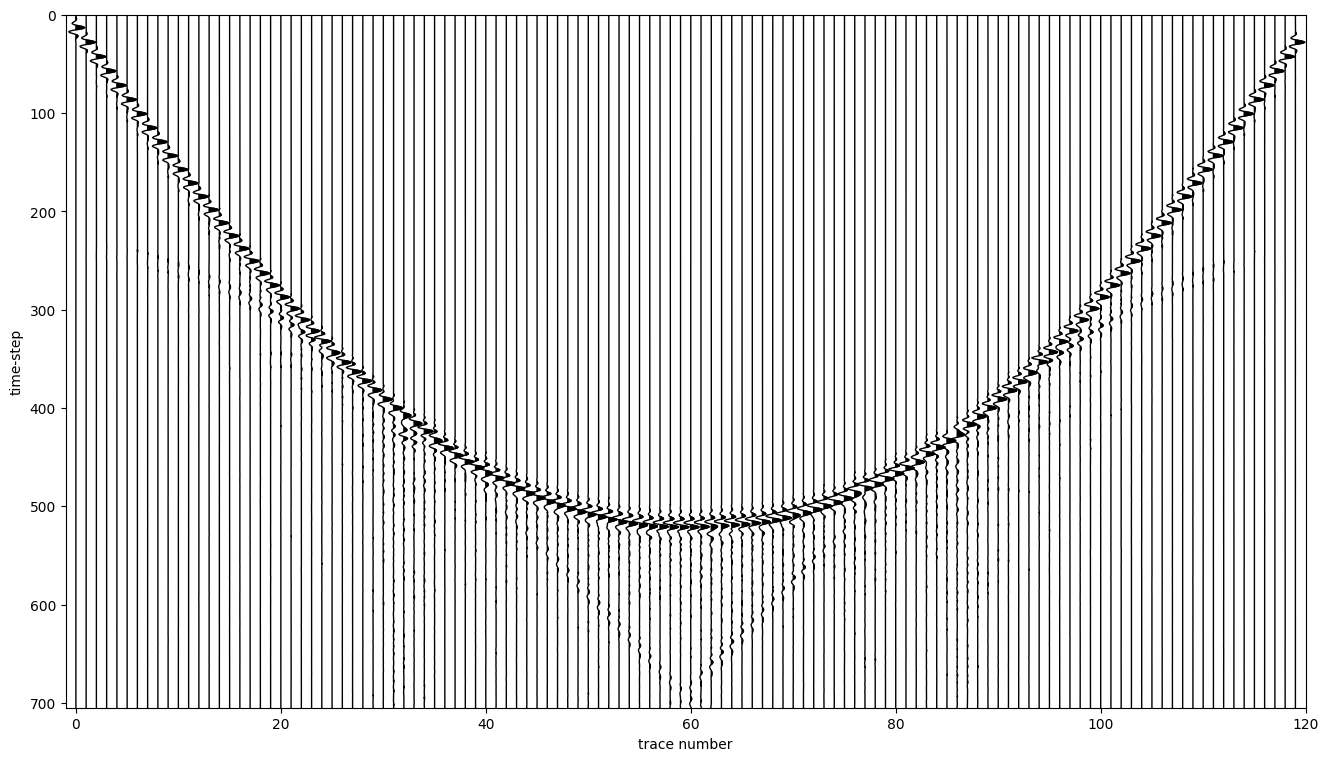

In [9]:
# Save the true modelled data
np.save('./data/d.npy', true_model.d.numpy())

from forge.utils import trace_plot, normalize

# Visualize traces of true modelled data
trace_plot(normalize(true_model.d), 0, scale_fac=1.8, size=(16, 9))